Характеристики и типы данных

Категориальные признаки:

Регион (числовой код географической области, идентифицирует либо крупный город, такой как Москва или Санкт-Петербург, либо федеральный округ/регион)

Тип здания (числовой код типа здания, в котором находится квартира)

Тип объекта (тип квартиры, где 1 означает вторичный рынок недвижимости, 11 - новостройка)

Числовые характеристики:

Площадь (общая площадь квартиры в кв. метрах)

Площадь кухни (площадь кухни в кв. метрах)

Комнаты (количество комнат в квартире, -1 обозначает студии с открытой планировкой)

Уровень (этаж, на котором расположена квартира, может также рассматриваться как категориальный признак)

Уровни (общее количество этажей в здании)

Геопространственные характеристики:

Широта - географическая координата объекта недвижимости

Долгота - географическая координата объекта недвижимости

Временные характеристики:

Дата (дата публикации объявления)

Время (точное время публикации объявления)

Импорт необходимых библиотек, также отключим предупреждения

In [1]:
import gc
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import joblib

from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

Укажем путь к датасету, выберем город и укажем диапазоны выбросов

In [2]:
PATH = 'all_v2.csv'

REGION_ID = 2661  # Город Санкт-Петербург

MIN_AREA = 20  # Диапазон выбросов для площади квартиры
MAX_AREA = 200

MIN_KITCHEN = 6  # Диапазон выбросов для площади кухни
MAX_KITCHEN = 30

MIN_PRICE = 1_500_000  # Диапазон выбросов для цен на квартиры
MAX_PRICE = 50_000_000

SEED = 15
N_FOLDS = 5

Необходимые функции

In [3]:
def set_display():
    '''Функция устанавливает параметры отображения для графиков и датафреймов Pandas'''
    # Настройки отображения графиков
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # Настройки отображения датафреймов
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    '''Функция удаляет лишние столбцы и обеспечивает правильные типы данных.'''
    df.drop('time', axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    # Заменяем отрицательные значения в столбце rooms на 0, так как они предполагаются как студии.
    df['rooms'] = df['rooms'].apply(lambda x: 0 if x < 0 else x)
    df['price'] = df['price'].abs()  # Исправление отрицательных значений в столбце price
    # Удаление выбросов по площади и цене
    df = df[(df['area'] <= MAX_AREA) & (df['area'] >= MIN_AREA)]
    df = df[(df['price'] <= MAX_PRICE) & (df['price'] >= MIN_PRICE)]
    # Исправление выбросов в столбце kitchen_area
    # Сначала заменим все выбросы на 0
    df.loc[(df['kitchen_area'] >= MAX_KITCHEN) | (df['area'] <= MIN_AREA), 'kitchen_area'] = 0
    # Затем рассчитаем площадь кухни, исходя из общей площади квартиры, за исключением студий
    erea_mean, kitchen_mean = df[['area', 'kitchen_area']].quantile(0.5)
    kitchen_share = kitchen_mean / erea_mean
    df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'kitchen_area'] = \
        df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'area'] * kitchen_share
    return df

def select_region(df: pd.DataFrame) -> pd.DataFrame:
    '''Функция для выбора объявлений по региону.'''
    df = df[df['region'] == REGION_ID]
    df.drop('region', axis=1, inplace=True)
    print(f'Selected {len(df)} samples in region {REGION_ID}.')
    return df

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    '''Функция для добавления новых признаков.'''
    # Преобразование столбца 'date' в числовые признаки для года и месяца
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)
    # Соотношение этажа квартиры к общему количеству этажей
    df['level_to_levels'] = df['level'] / df['levels']
    # Средний размер комнаты в квартире
    df['area_to_rooms'] = (df['area'] / df['rooms']).abs()
    # Исправление деления на ноль
    df.loc[df['area_to_rooms'] == np.inf, 'area_to_rooms'] = \
        df.loc[df['area_to_rooms'] == np.inf, 'area']
    return df

def set_seed(seed=42):
    '''Функция полезности, используемая для воспроизводимости.'''
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

Вызовем функцию для настройки отображения графиков

In [4]:
set_display()

Чтение и вывод данных

In [5]:
data = pd.read_csv(PATH)
print(f'Data shape: {data.shape}')
data.head()

Data shape: (5477006, 13)


,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.8058,30.3761,2661,1,8,10,3,82.6000,10.8000,1
1,8650000,2018-02-27,12:04:54,55.6838,37.2974,81,3,5,24,2,69.1000,12.0000,1
2,4000000,2018-02-28,15:44:00,56.2953,44.0616,2871,1,5,9,3,66.0000,10.0000,1
3,1850000,2018-03-01,11:24:52,44.9961,39.0748,2843,4,12,16,2,38.0000,5.0000,11
4,5450000,2018-03-01,17:42:43,55.9188,37.9846,81,3,13,14,2,60.0000,10.0000,1


Структура и содержание датафрейма

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


Описательная статистика датафрейма

In [7]:
data.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000
mean,4422029.0229,54.0383,53.2443,4307.1409,1.9490,6.2145,11.3989,1.7262,53.9182,10.6284,3.9454
std,21507519.1548,4.6228,20.7476,3308.0502,1.0385,4.9574,6.5357,1.0821,33.3529,9.7924,4.5584
min,-2144967296.0000,41.4591,19.8902,3.0000,0.0000,1.0000,1.0000,-2.0000,0.0700,0.0100,1.0000
25%,1950000.0000,53.3777,37.7779,2661.0000,1.0000,2.0000,5.0000,1.0000,38.0000,7.0000,1.0000
50%,2990000.0000,55.1714,43.0677,2922.0000,2.0000,5.0000,10.0000,2.0000,48.0200,9.7000,1.0000
75%,4802000.0000,56.2261,65.6489,6171.0000,3.0000,9.0000,16.0000,2.0000,63.1300,12.7000,11.0000
max,2147483647.0000,71.9804,162.5361,61888.0000,5.0000,39.0000,39.0000,10.0000,7856.0000,9999.0000,11.0000


Очистка данных

In [8]:
data = data.pipe(clean_data)
data.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,59.8058,30.3761,2661,1,8,10,3,82.6000,10.8000,1
1,8650000,2018-02-27,55.6838,37.2974,81,3,5,24,2,69.1000,12.0000,1
2,4000000,2018-02-28,56.2953,44.0616,2871,1,5,9,3,66.0000,10.0000,1
3,1850000,2018-03-01,44.9961,39.0748,2843,4,12,16,2,38.0000,5.0000,11
4,5450000,2018-03-01,55.9188,37.9846,81,3,13,14,2,60.0000,10.0000,1


Построение круговой диаграммы для типов зданий

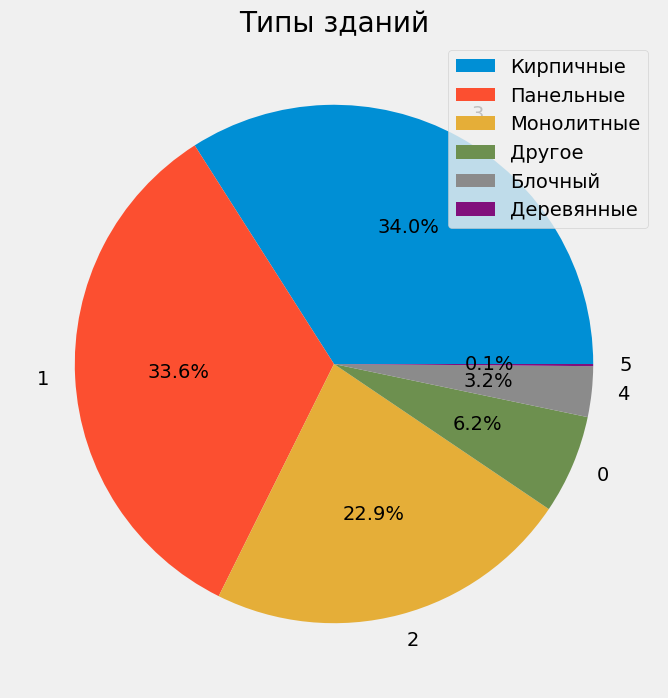

In [16]:
building_types = data['building_type'].value_counts()
plt.pie(building_types.values, labels=building_types.index, autopct='%1.1f%%')
plt.title('Типы зданий')
plt.legend(['Кирпичные', 'Панельные', 'Монолитные', 'Другое', 'Блочный', 'Деревянные'])
plt.show()

Построение круговой диаграммы для типов квартир

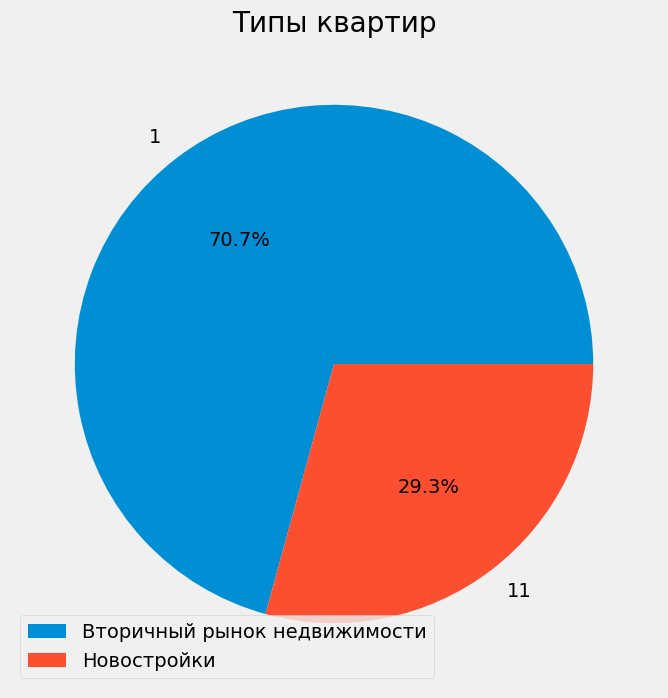

In [17]:
apartment_types = data['object_type'].value_counts()
plt.pie(apartment_types.values, labels=apartment_types.index, autopct='%1.1f%%')
plt.title('Типы квартир')
plt.legend(['Вторичный рынок недвижимости', 'Новостройки'])
plt.show()

Построение круговой диаграммы для количества комнат

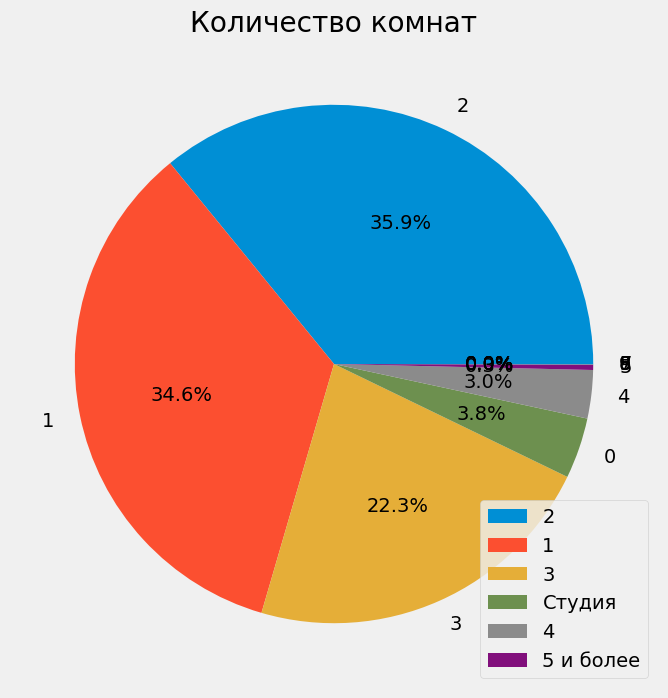

In [25]:
rooms = data['rooms'].value_counts()
plt.pie(rooms.values, labels=rooms.index, autopct='%1.1f%%')
plt.title('Количество комнат')
plt.legend(['2', '1', '3', 'Студия', '4', '5 и более'])
plt.show()

Визуализация распределения площади квартиры и площади кухни

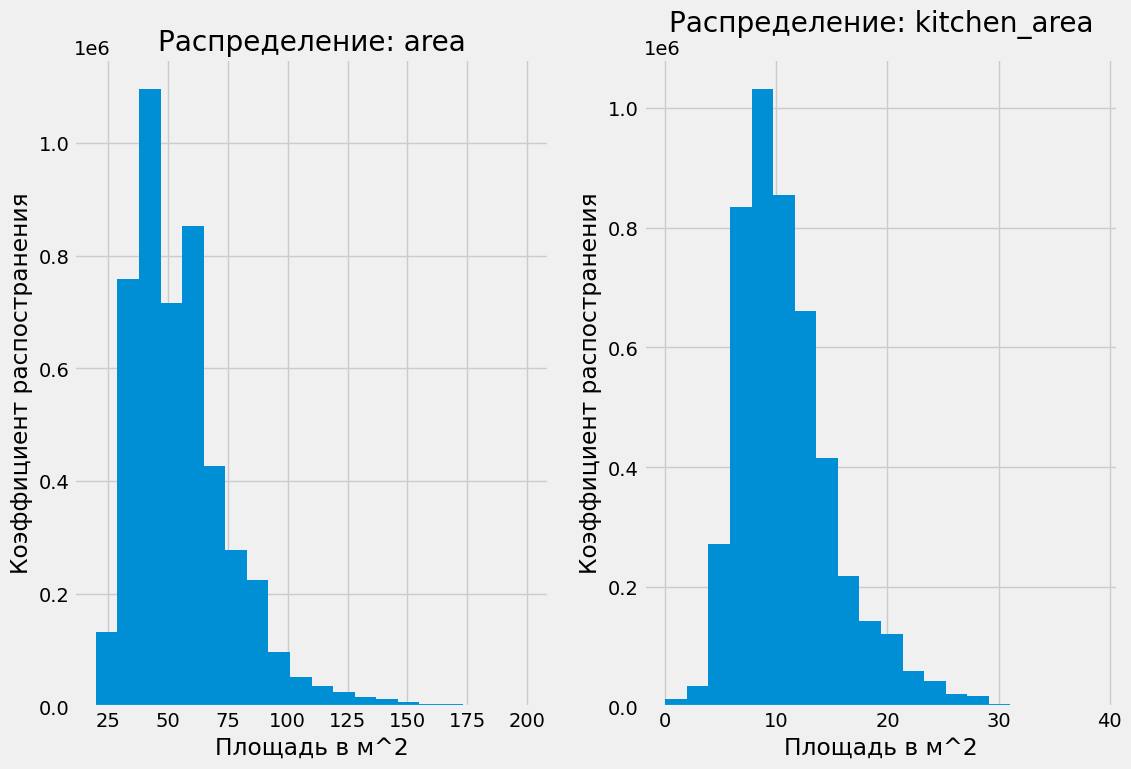

In [31]:
pos = 0
for pos, feature in enumerate(['area', 'kitchen_area']):
    sp = plt.subplot(1, 2, pos + 1)
    plt.hist(data[feature], bins=20)
    plt.title(f'Распределение: {feature}')
    plt.xlabel('Площадь в м^2')
    plt.ylabel('Коэффициент распостранения')
plt.show()

Визуализация этажа квартиры и общего количества этажей в доме

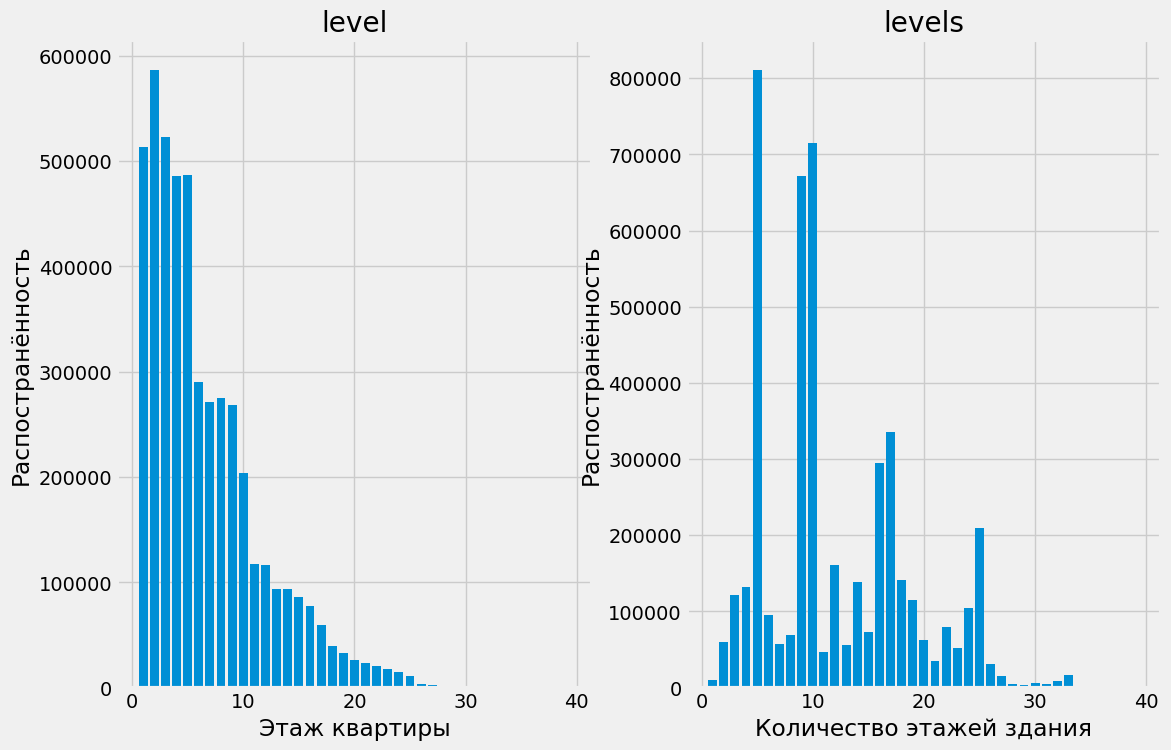

In [38]:
pos = 0
for pos, feature in enumerate(['level', 'levels']):
    levels = data[feature].value_counts()
    sp = plt.subplot(1, 2, pos + 1)
    plt.bar(levels.index, levels.values)
    plt.title(feature)
    plt.xlabel('Количество этажей здания') if feature[-1] == 's' else plt.xlabel('Этаж квартиры')
    plt.ylabel('Распостранённость')
plt.show()

Применение функций для фильтрации данных и добавления новых признаков

In [17]:
data = data.pipe(select_region)
data = data.pipe(add_features)
data.head()

Selected 453621 samples in region 2661.


,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
0,6050000,59.8058,30.3761,1,8,10,3,82.6000,10.8000,1,2018,2,0.8000,27.5333
7,3600000,59.8755,30.3955,1,2,5,1,31.1000,6.0000,1,2018,3,0.4000,31.1000
36,3200000,59.8275,30.2018,1,7,9,1,31.0000,7.0000,1,2018,4,0.7778,31.0000
47,6500000,59.9883,29.7869,3,3,3,3,89.0000,10.0000,1,2018,4,1.0000,29.6667
54,6300000,59.9116,30.2846,3,5,5,2,99.9000,14.5000,1,2018,4,1.0000,49.9500


Освобождение памяти

In [18]:
gc.collect()

13491

Описательная статистика для подготовленного датафрейма

In [19]:
data.describe()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
count,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000
mean,7663511.1338,59.9327,30.3196,1.9443,7.6222,14.4329,1.8193,57.0727,12.1962,5.3045,2019.5454,6.5346,0.5435,32.6040
std,5601934.2405,0.0850,0.1206,0.9523,5.7030,7.0618,0.9760,26.6006,5.1952,4.9514,0.8555,3.4328,0.2822,9.8309
min,1500000.0000,59.6474,29.5093,0.0000,1.0000,1.0000,0.0000,20.0000,0.0000,1.0000,2018.0000,1.0000,0.0323,2.8750
25%,4437600.0000,59.8631,30.2568,1.0000,3.0000,9.0000,1.0000,37.7000,8.5000,1.0000,2019.0000,3.0000,0.3000,26.0000
50%,5940000.0000,59.9391,30.3243,2.0000,6.0000,13.0000,2.0000,50.9000,11.1000,1.0000,2020.0000,7.0000,0.5385,31.5500
75%,8711033.0000,60.0003,30.3995,3.0000,11.0000,21.0000,2.0000,68.1000,15.0000,11.0000,2020.0000,10.0000,0.7895,37.5000
max,50000000.0000,60.2420,30.7114,5.0000,35.0000,38.0000,9.0000,200.0000,38.8350,11.0000,2021.0000,12.0000,4.0000,198.0000


Построение матрицы корреляции и ее визуализация

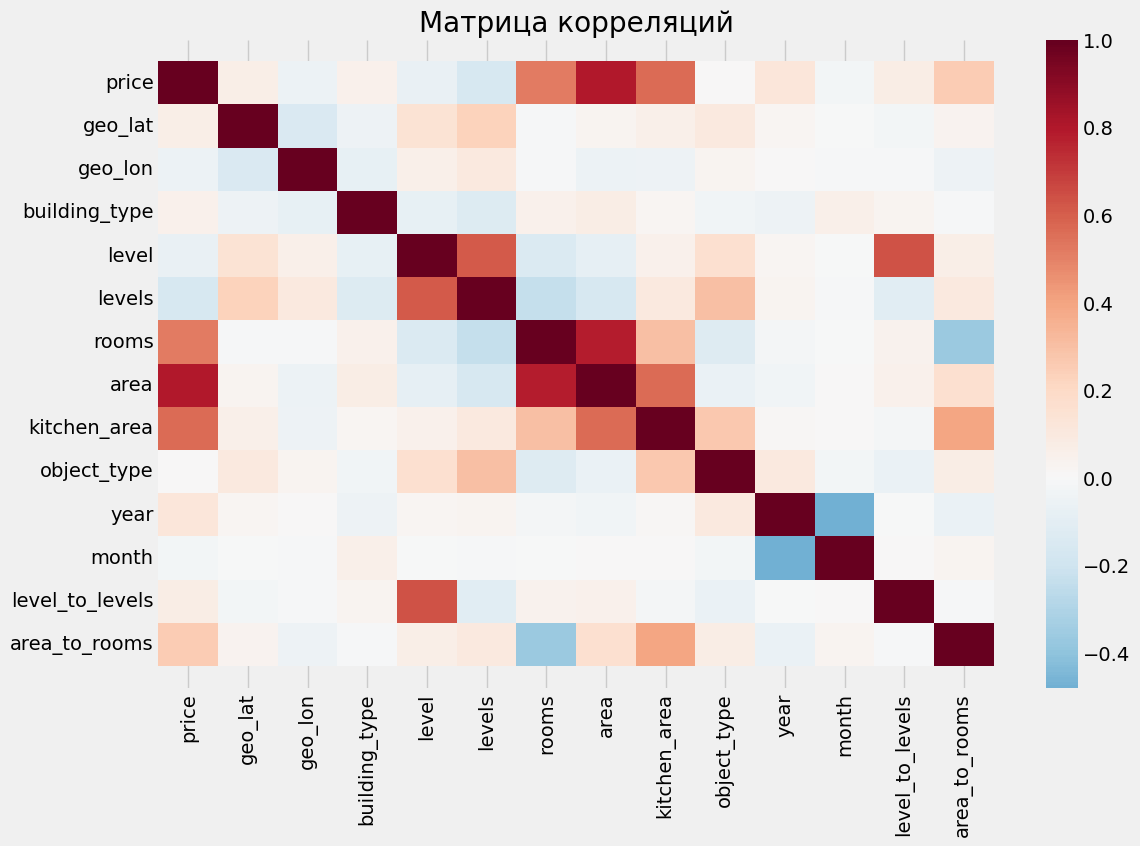

In [20]:
correlation = data.corr()
ax = sns.heatmap(correlation, center=0, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Матрица корреляций')
plt.show()

Отделение целевой переменной 'price'

In [20]:
y = data.pop('price')

Создаём словарь с уникальными значениями признаков

In [22]:
dict_unique = {key: data[key].unique().tolist() for key in data.columns}

In [24]:
with open('unique_values.json', 'w') as file:
    json.dump(dict_unique, file)

Установка случайного зерна для воспроизводимости и создание объекта KFold для кросс-валидации

In [21]:
set_seed(SEED)

kf = KFold(N_FOLDS, shuffle=True, random_state=SEED)

Модель XGBoost

In [33]:
scores = [] # Список для хранения результатов RMSE для каждого фолда

for train_index, test_index in kf.split(data, y): # Разделение данных на обучающие и тестовые наборы

    x_train, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', early_stopping_rounds=50) # Инициализация модели


    model_xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], # Обучение модели
                  verbose=0)

    scores.append(model_xgb.best_score)
    model_xgb.save_model(f'xgboost{len(scores)}.bin') # Сохранение результатов

print('XGBoost average RMSE:', np.mean(scores)) # Подведение итогов
for i, score in enumerate(scores):
    print(f'Model {i} RMSE: {score}')

XGBoost average RMSE: 1795992.5713202239
Model 0 RMSE: 1828084.1774660426
Model 1 RMSE: 1810979.0382034385
Model 2 RMSE: 1777964.6991863046
Model 3 RMSE: 1787009.2769846022
Model 4 RMSE: 1775925.664760732


Важность признаков модели XGBoost

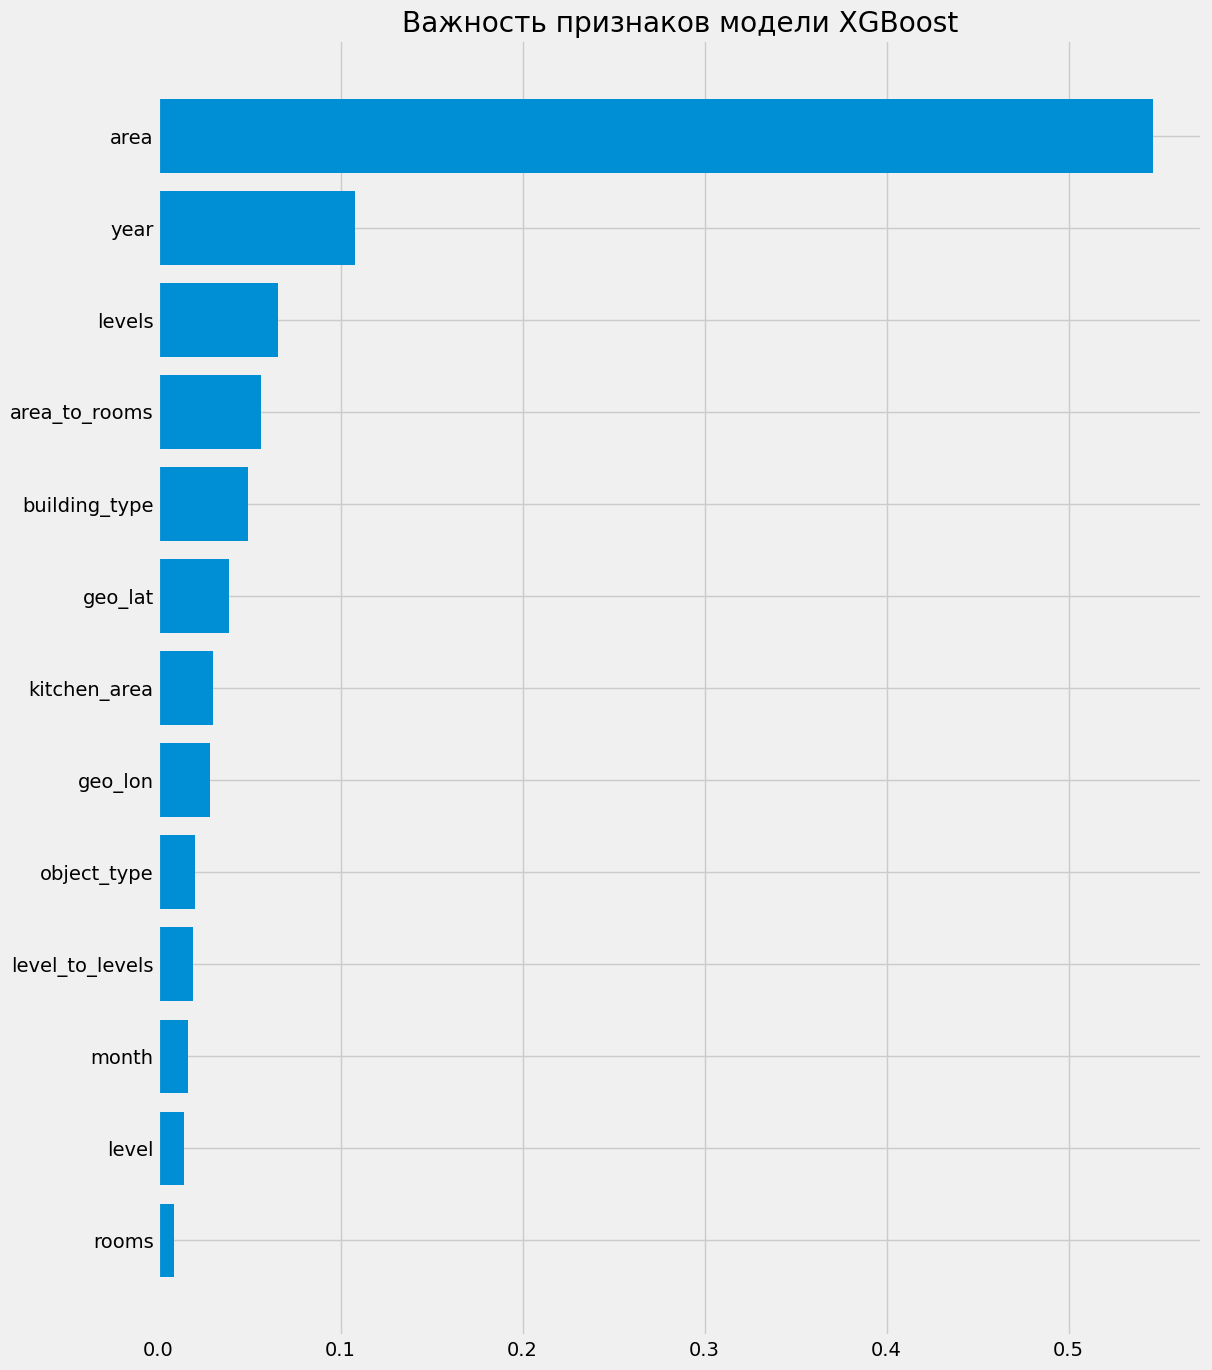

In [51]:
importance = pd.DataFrame({
    'features': data.columns,
    'importance': model_xgb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('Важность признаков модели XGBoost')
plt.show()

Модель LightGBM

In [54]:
scores = []

for train_index, test_index in kf.split(data, y):

    x_train, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgb = LGBMRegressor(objective='regression', metrics='rmse', early_stopping_rounds=50, verbose=-1)

    model_lgb.fit(x_train, y_train, eval_set=(x_test, y_test),
                  eval_metric='rmse', 
                  categorical_feature=['building_type', 'object_type', 'month']
                  )

    scores.append(model_lgb.best_score_['valid_0']['rmse'])
    model_lgb.booster_.save_model(f'lgbm{len(scores)}.txt',
                                  num_iteration=model_lgb.best_iteration_)

print('LightGBM average RMSE:', np.mean(scores))
for i, score in enumerate(scores):
    print(f'Model {i} RMSE: {score}')

LightGBM average RMSE: 1944575.1940743967
Model 0 RMSE: 1967774.511641701
Model 1 RMSE: 1970392.634845901
Model 2 RMSE: 1924283.2638095252
Model 3 RMSE: 1940086.26328234
Model 4 RMSE: 1920339.2967925158


Важность признаков модели LightGBM

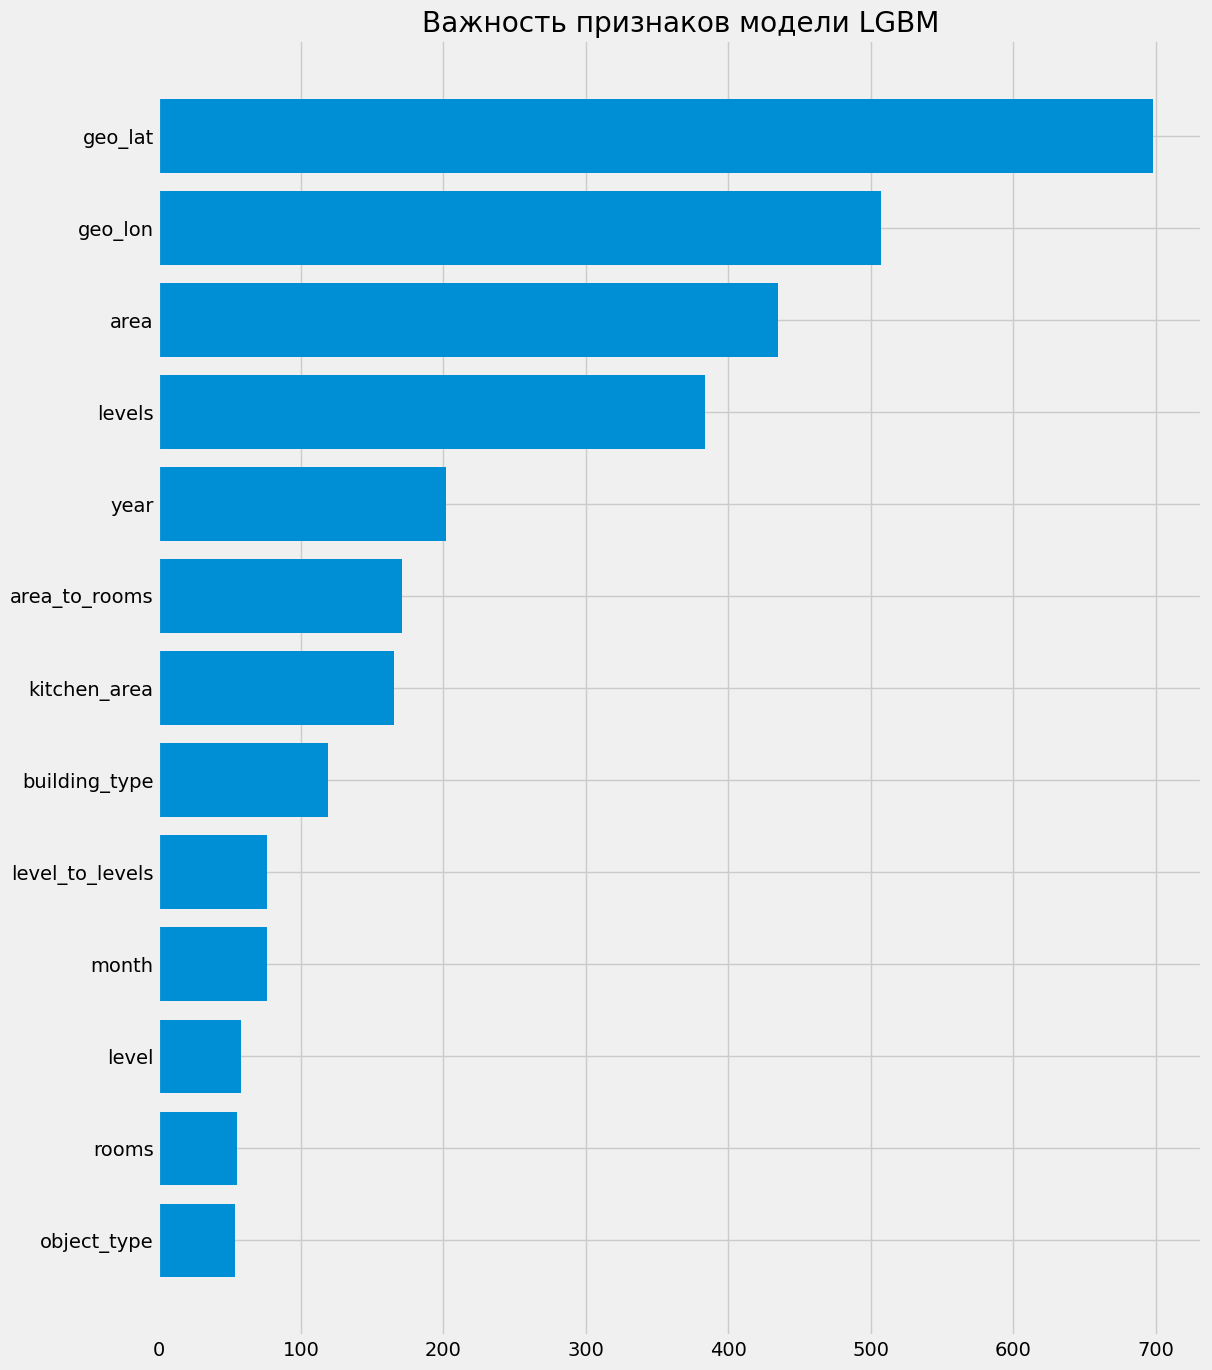

In [55]:
importance = pd.DataFrame({
    'features': data.columns,
    'importance': model_lgb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('Важность признаков модели LGBM')
plt.show()

Модель CatBoost

In [41]:
scores = []

for train_index, test_index in kf.split(data, y):

    x_train, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_cb = CatBoostRegressor(eval_metric='RMSE',
                                 cat_features=['building_type', 'object_type', 'month'])
    model_cb.fit(x_train, y_train, eval_set=[(x_test, y_test)],
                 early_stopping_rounds=20, use_best_model=True,
                 verbose=0)

    scores.append(model_cb.best_score_['validation']['RMSE'])
    model_cb.save_model(f'catboost{len(scores)}.cbm')

print('Average RMSE:', np.mean(scores))
for i, score in enumerate(scores):
    print(f'Model {i} RMSE: {score}')

Average RMSE: 1735834.5166338552
Model 0 RMSE: 1763860.7223120295
Model 1 RMSE: 1743654.0839787477
Model 2 RMSE: 1718068.9236082523
Model 3 RMSE: 1735937.8053026563
Model 4 RMSE: 1717651.0479675902


Важность признаков модели CatBoost

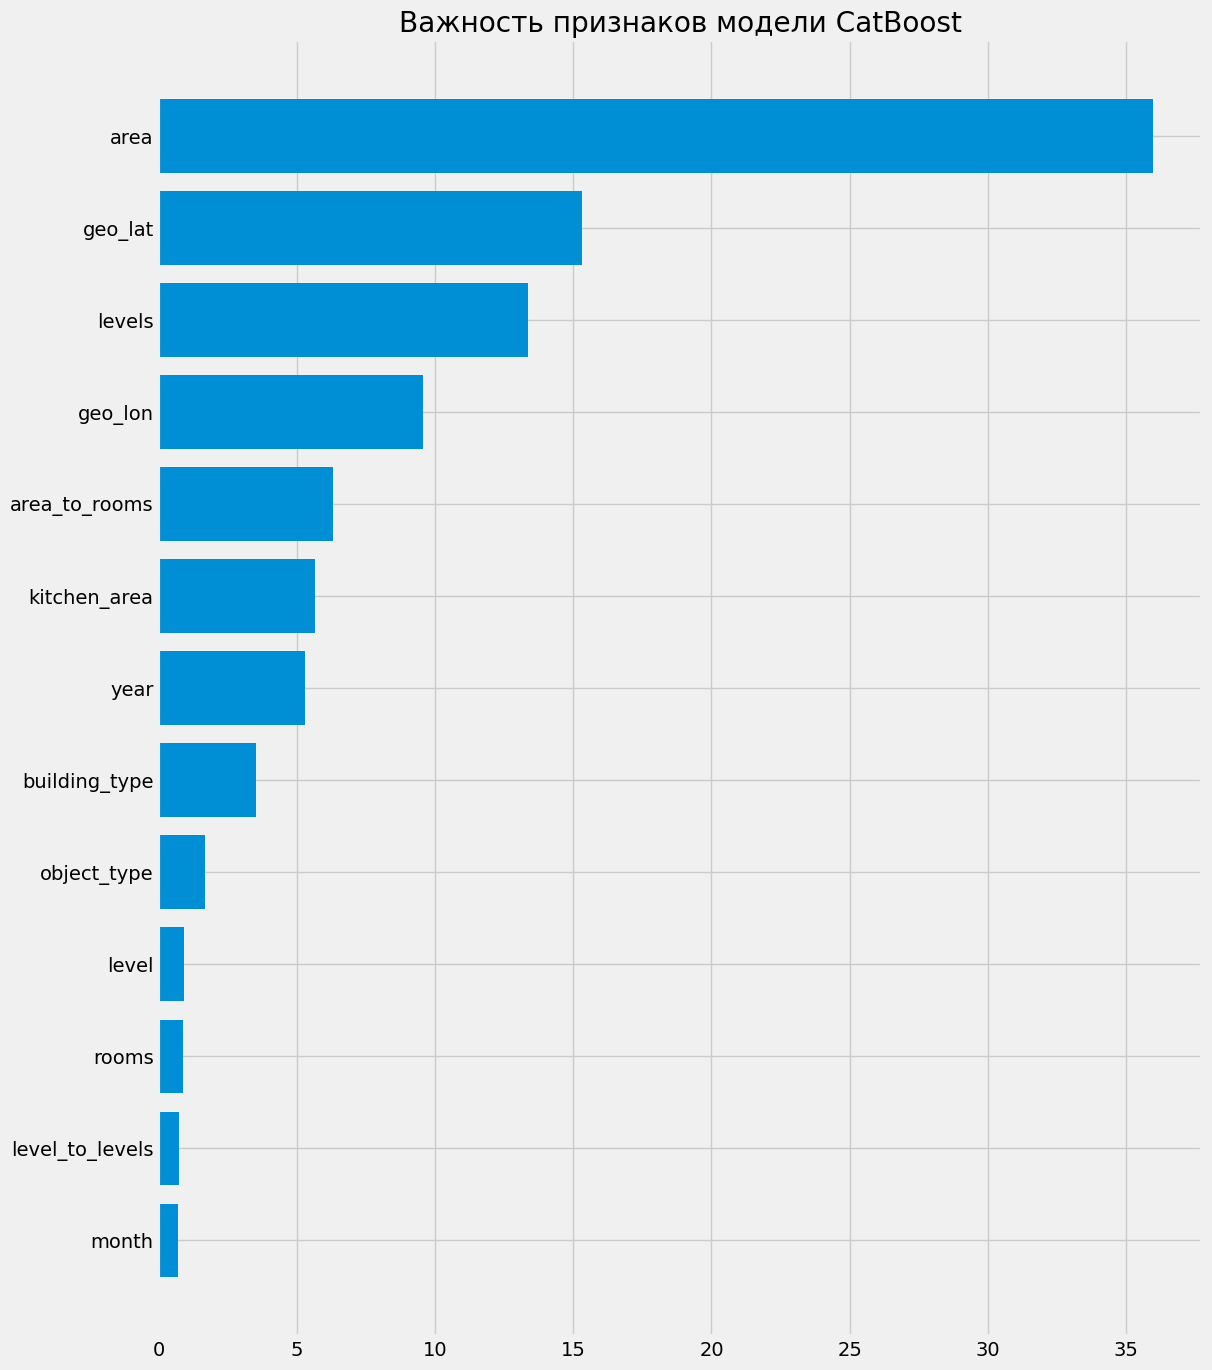

In [53]:
importance = pd.DataFrame({
    'features': data.columns,
    'importance': model_cb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('Важность признаков модели CatBoost')
plt.show()